<a href="https://colab.research.google.com/github/rainardw/TUBES_PEMPAR/blob/main/TUGAS_BESAR_PEMPAR_KELOMPOK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Anggota Kelompok
group_members = {
    "ADITYA": "F1D02310",
    "DATU REKSA HAMZA PUTRA": "F1D02310",
    "KURNIA DWI SURYA": "F1D02310013"
}

# Link Dataset Kaggle
kaggle_link = "https://www.kaggle.com/datasets/yug201/disease-cancer-heart-liver"

print("ANGGOTA KELOMPOK 7:")
for name, nim in group_members.items():
    print(f"{name} - {nim}")

print("\nLink Dataset:", kaggle_link)


ANGGOTA KELOMPOK 7:
ADITYA - F1D02310
DATU REKSA HAMZA PUTRA - F1D02310
KURNIA DWI SURYA - F1D02310013

Link Dataset: https://www.kaggle.com/datasets/yug201/disease-cancer-heart-liver


In [ ]:
from pyspark.sql.functions import lit
from pyspark.sql.types import StringType, IntegerType
from pyspark import SparkContext
from pyspark.sql import SparkSession
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing as mp
from mpi4py import MPI

In [41]:
!pip install pyspark
sc = SparkContext.getOrCreate()
spark = SparkSession.builder.appName("DiseaseAnalysis").getOrCreate()

In [60]:
rdd_heart = sc.textFile("heart.csv")
rdd_cancer = sc.textFile("cancer patient data sets.csv")
rdd_liver = sc.textFile("indian_liver_patient (1).csv")

header = rdd_heart.first()

data_heart = rdd_heart.filter(lambda row: row != header)
data_cancer = rdd_cancer.filter(lambda row: row != header)
data_liver = rdd_liver.filter(lambda row: row != header)

# Gabungkan semua data
data_all = data_heart.union(data_cancer).union(data_liver)

# Filter penyakit 'Heart Disease'
filtered_heart = data_all.filter(lambda row: "Heart Disease" in row)

# Tampilkan hasil
print("Contoh baris dengan Heart Disease:")
print(filtered_heart.take(5))

# Hitung jumlah kasus
heart_count = filtered_heart.count()
print(f"Jumlah kasus Heart Disease: {heart_count}")


Contoh baris dengan Heart Disease:
[]
Jumlah kasus Heart Disease: 0


In [51]:
# Buat SparkSession
spark = SparkSession.builder.appName("AnalisisPenyakit").getOrCreate()

# Baca CSV
df_heart = spark.read.csv("/heart.csv", header=True, inferSchema=True)
df_heart.show(5)
df_heart.printSchema()

df_cancer = spark.read.csv("/cancer patient data sets.csv", header=True, inferSchema=True)
df_cancer.show(5)
df_cancer.printSchema()

df_liver = spark.read.csv("/indian_liver_patient (1).csv", header=True, inferSchema=True)
df_liver.show(5)
df_liver.printSchema()

+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+
|Age|Sex|ChestPainType|RestingBP|Cholesterol|FastingBS|RestingECG|MaxHR|ExerciseAngina|Oldpeak|ST_Slope|HeartDisease|
+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+
| 40|  M|          ATA|      140|        289|        0|    Normal|  172|             N|    0.0|      Up|           0|
| 49|  F|          NAP|      160|        180|        0|    Normal|  156|             N|    1.0|    Flat|           1|
| 37|  M|          ATA|      130|        283|        0|        ST|   98|             N|    0.0|      Up|           0|
| 48|  F|          ASY|      138|        214|        0|    Normal|  108|             Y|    1.5|    Flat|           1|
| 54|  M|          NAP|      150|        195|        0|    Normal|  122|             N|    0.0|      Up|           0|
+---+---+-------------+---------+-----------+---------+-

In [21]:
def cek_null(df, nama_dataset):
    print(f"\nJumlah null pada dataset {nama_dataset}:")
    df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

cek_null(df_heart, "Heart")
cek_null(df_cancer, "Cancer")
cek_null(df_liver, "Liver")


Jumlah null pada dataset Heart:
+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+
|Age|Sex|ChestPainType|RestingBP|Cholesterol|FastingBS|RestingECG|MaxHR|ExerciseAngina|Oldpeak|ST_Slope|HeartDisease|
+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+
|  0|  0|            0|        0|          0|        0|         0|    0|             0|      0|       0|           0|
+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+


Jumlah null pada dataset Cancer:
+-----+----------+---+------+-------------+-----------+------------+--------------------+------------+--------------------+-------------+-------+-------+--------------+----------+-----------------+-------+-----------+-------------------+--------+---------------------+------------------------+-------------+---------+-------+-----+
|index|Pat

In [25]:
df_heart.groupBy("HeartDisease").count().show()
df_liver.groupBy("Dataset").count().show()
df_cancer.groupBy("Level").count().show()

+------------+-----+
|HeartDisease|count|
+------------+-----+
|           1|  508|
|           0|  410|
+------------+-----+

+-------+-----+
|Dataset|count|
+-------+-----+
|      1|  416|
|      2|  167|
+-------+-----+

+------+-----+
| Level|count|
+------+-----+
|  High|  365|
|   Low|  303|
|Medium|  332|
+------+-----+



In [28]:
print("\nStatistik Heart Dataset:")
df_heart.select(
    round(avg("Age"), 2).alias("Rata-rata Usia"),
    round(avg("Cholesterol"), 2).alias("Rata-rata Kolesterol"),
    round(avg("MaxHR"), 2).alias("Rata-rata Detak Jantung Maks")
).show()


Statistik Heart Dataset:
+--------------+--------------------+----------------------------+
|Rata-rata Usia|Rata-rata Kolesterol|Rata-rata Detak Jantung Maks|
+--------------+--------------------+----------------------------+
|         53.51|               198.8|                      136.81|
+--------------+--------------------+----------------------------+



In [27]:
from pyspark.sql.functions import avg, round

df.select(
    round(avg("Age"), 2).alias("Rata-rata Usia"),
    round(avg("Cholesterol"), 2).alias("Rata-rata Kolesterol"),
    round(avg("MaxHR"), 2).alias("Rata-rata Detak Jantung Maks")
).show()

+--------------+--------------------+----------------------------+
|Rata-rata Usia|Rata-rata Kolesterol|Rata-rata Detak Jantung Maks|
+--------------+--------------------+----------------------------+
|         53.51|               198.8|                      136.81|
+--------------+--------------------+----------------------------+



In [26]:
print("\nPasien dengan kolesterol > 240 dan usia > 50:")
df_heart.filter((col("Cholesterol") > 240) & (col("Age") > 50)).show(5)


Pasien dengan kolesterol > 240 dan usia > 50:
+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+
|Age|Sex|ChestPainType|RestingBP|Cholesterol|FastingBS|RestingECG|MaxHR|ExerciseAngina|Oldpeak|ST_Slope|HeartDisease|
+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+
| 54|  F|          ATA|      120|        273|        0|    Normal|  150|             N|    1.5|    Flat|           0|
| 60|  M|          ASY|      100|        248|        0|    Normal|  125|             N|    1.0|    Flat|           1|
| 53|  M|          ASY|      124|        260|        0|        ST|  112|             Y|    3.0|    Flat|           0|
| 52|  M|          ATA|      120|        284|        0|    Normal|  118|             N|    0.0|      Up|           0|
| 53|  F|          ATA|      113|        468|        0|    Normal|  127|             N|    0.0|      Up|           0|
+---+---+

In [10]:
rdd = df.rdd

gender_count = rdd.map(lambda row: (row["Sex"], 1)).reduceByKey(lambda a, b: a + b)
gender_count.collect()

[('M', 725), ('F', 193)]

In [12]:
df.createOrReplaceTempView("data_penyakit")

spark.sql("SELECT Sex, COUNT(*) as Jumlah FROM data_penyakit GROUP BY Sex").show()

+---+------+
|Sex|Jumlah|
+---+------+
|  F|   193|
|  M|   725|
+---+------+



In [29]:
print("\nStatistik Cancer Dataset:")
df_cancer.select(
    round(avg("Age"), 2).alias("Rata-rata Usia"),
    round(avg("Genetic Risk"), 2).alias("Rata-rata Risiko Genetik")
).show()


Statistik Cancer Dataset:
+--------------+------------------------+
|Rata-rata Usia|Rata-rata Risiko Genetik|
+--------------+------------------------+
|         37.17|                    4.58|
+--------------+------------------------+



In [37]:
print("\nFiltering pasien dengan risiko genetik > 0 dan usia > 50:")
df_cancer.filter((col("Genetic Risk") > 0) & (col("Age") > 50)).show(5)


Filtering pasien dengan risiko genetik > 0 dan usia > 50:
+-----+----------+---+------+-------------+-----------+------------+--------------------+------------+--------------------+-------------+-------+-------+--------------+----------+-----------------+-------+-----------+-------------------+--------+---------------------+------------------------+-------------+---------+-------+------+
|index|Patient Id|Age|Gender|Air Pollution|Alcohol use|Dust Allergy|OccuPational Hazards|Genetic Risk|chronic Lung Disease|Balanced Diet|Obesity|Smoking|Passive Smoker|Chest Pain|Coughing of Blood|Fatigue|Weight Loss|Shortness of Breath|Wheezing|Swallowing Difficulty|Clubbing of Finger Nails|Frequent Cold|Dry Cough|Snoring| Level|
+-----+----------+---+------+-------------+-----------+------------+--------------------+------------+--------------------+-------------+-------+-------+--------------+----------+-----------------+-------+-----------+-------------------+--------+---------------------+-------

In [31]:
print("\nRDD ReduceByKey - Gender Count (Cancer):")
rdd_cancer = df_cancer.rdd
gender_cancer = rdd_cancer.map(lambda row: (row["Gender"], 1)).reduceByKey(lambda a, b: a + b)
for gender, count in gender_cancer.collect():
    print(f"{gender}: {count}")


RDD ReduceByKey - Gender Count (Cancer):
1: 598
2: 402


In [32]:
df_cancer.createOrReplaceTempView("data_cancer")
print("\nQuery jumlah pasien berdasarkan gender (Cancer):")
spark.sql("SELECT Gender, COUNT(*) as Jumlah FROM data_cancer GROUP BY Gender").show()


Query jumlah pasien berdasarkan gender (Cancer):
+------+------+
|Gender|Jumlah|
+------+------+
|     1|   598|
|     2|   402|
+------+------+



In [33]:
print("\nStatistik Liver Dataset:")
df_liver.select(
    round(avg("Age"), 2).alias("Rata-rata Usia"),
    round(avg("Total_Bilirubin"), 2).alias("Rata-rata Bilirubin Total")
).show()


Statistik Liver Dataset:
+--------------+-------------------------+
|Rata-rata Usia|Rata-rata Bilirubin Total|
+--------------+-------------------------+
|         44.75|                      3.3|
+--------------+-------------------------+



In [34]:

print("\nFiltering pasien dengan Total_Bilirubin > 2 dan usia > 50:")
df_liver.filter((col("Total_Bilirubin") > 2) & (col("Age") > 50)).show(5)


Filtering pasien dengan Total_Bilirubin > 2 dan usia > 50:
+---+------+---------------+----------------+--------------------+------------------------+--------------------------+--------------+-------+--------------------------+-------+
|Age|Gender|Total_Bilirubin|Direct_Bilirubin|Alkaline_Phosphotase|Alamine_Aminotransferase|Aspartate_Aminotransferase|Total_Protiens|Albumin|Albumin_and_Globulin_Ratio|Dataset|
+---+------+---------------+----------------+--------------------+------------------------+--------------------------+--------------+-------+--------------------------+-------+
| 62|  Male|           10.9|             5.5|                 699|                      64|                       100|           7.5|    3.2|                      0.74|      1|
| 62|  Male|            7.3|             4.1|                 490|                      60|                        68|           7.0|    3.3|                      0.89|      1|
| 72|  Male|            3.9|             2.0|          

In [35]:
print("\nRDD ReduceByKey - Gender Count (Liver):")
rdd_liver = df_liver.rdd
gender_liver = rdd_liver.map(lambda row: (row["Gender"], 1)).reduceByKey(lambda a, b: a + b)
for gender, count in gender_liver.collect():
    print(f"{gender}: {count}")


RDD ReduceByKey - Gender Count (Liver):
Female: 142
Male: 441


In [36]:
df_liver.createOrReplaceTempView("data_liver")
print("\nQuery jumlah pasien berdasarkan gender (Liver):")
spark.sql("SELECT Gender, COUNT(*) as Jumlah FROM data_liver GROUP BY Gender").show()


Query jumlah pasien berdasarkan gender (Liver):
+------+------+
|Gender|Jumlah|
+------+------+
|Female|   142|
|  Male|   441|
+------+------+



In [38]:
# Simulasi pengolahan Heart Dataset pakai MPI

data = [
    {"Sex": "M"}, {"Sex": "F"}, {"Sex": "M"}, {"Sex": "F"},
    {"Sex": "F"}, {"Sex": "M"}, {"Sex": "M"}, {"Sex": "F"}
]

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

chunk_size = len(data) // size
start = rank * chunk_size
end = start + chunk_size if rank != size - 1 else len(data)
local_data = data[start:end]

# Hitung jumlah pria dan wanita di tiap proses
local_result = {"M": 0, "F": 0}
for item in local_data:
    local_result[item["Sex"]] += 1

# Kumpulkan hasil ke proses 0
global_result = comm.reduce(local_result, op=MPI.SUM, root=0)

if rank == 0:
    print("Hasil akhir jumlah gender (MPI Reduce):", global_result)


ModuleNotFoundError: No module named 'mpi4py'

In [75]:
# Inisialisasi MPI
comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

# Fungsi load dan bagi data
def load_and_split(path):
    df = pd.read_csv(path)
    chunks = [df.iloc[i::size, :].reset_index(drop=True) for i in range(size)]
    return chunks

if rank == 0:
    # Load dan split data untuk masing-masing dataset
    heart_chunks = load_and_split("/heart.csv")
    cancer_chunks = load_and_split("/cancer patient data sets.csv")
    liver_chunks = load_and_split("/indian_liver_patient (1).csv")
else:
    heart_chunks = None
    cancer_chunks = None
    liver_chunks = None

# Scatter data ke masing-masing proses
heart_chunk = comm.scatter(heart_chunks, root=0)
cancer_chunk = comm.scatter(cancer_chunks, root=0)
liver_chunk = comm.scatter(liver_chunks, root=0)

# ================= HEART DATASET =================
# Filter pasien dengan HeartDisease == 1
heart_filtered = heart_chunk[heart_chunk["HeartDisease"] == 1]
heart_count_local = len(heart_filtered)
heart_count_total = comm.reduce(heart_count_local, op=MPI.SUM, root=0)

# ================= CANCER DATASET =================
# Misal filter pasien dengan Level tertentu, ganti sesuai kolom di dataset
# Contoh: Level == 'Low' (ubah sesuai dataset asli kamu)
cancer_filtered = cancer_chunk[cancer_chunk["Level"] == "Low"]
cancer_count_local = len(cancer_filtered)
cancer_count_total = comm.reduce(cancer_count_local, op=MPI.SUM, root=0)

# ================= LIVER DATASET =================
# Misal filter pasien dengan Dataset == 1 (ganti sesuai kolom dan kondisi dataset asli)
liver_filtered = liver_chunk[liver_chunk["Dataset"] == 1]
liver_count_local = len(liver_filtered)
liver_count_total = comm.reduce(liver_count_local, op=MPI.SUM, root=0)

if rank == 0:
    print(f"Total pasien HeartDisease == 1: {heart_count_total}")
    print(f"Total pasien Cancer Level == 'Low': {cancer_count_total}")
    print(f"Total pasien Liver Dataset == 1: {liver_count_total}")


ModuleNotFoundError: No module named 'mpi4py'

In [69]:
# Kolom yang kita butuhkan (supaya konsisten)
columns_needed = ["Age", "Sex", "JenisPenyakit"]

# Tambahkan kolom 'JenisPenyakit' di masing-masing dataset
df_heart = df_heart.withColumn("JenisPenyakit", lit("Heart Disease"))
df_cancer = df_cancer.withColumn("JenisPenyakit", lit("Cancer"))
df_liver = df_liver.withColumn("JenisPenyakit", lit("Liver Disease"))

def add_missing_cols(df, columns):
    # Cek kolom yang gak ada
    existing_cols = df.columns
    missing_cols = [c for c in columns if c not in existing_cols]
    # Tambahkan kolom kosong (null) dengan tipe string untuk yang hilang
    for col_name in missing_cols:
        df = df.withColumn(col_name, lit(None).cast(StringType()))
    # Pilih kolom sesuai urutan yang diinginkan
    return df.select(columns)

# Perbaiki tiap dataframe agar kolomnya sama
df_heart_fixed = add_missing_cols(df_heart, columns_needed)
df_cancer_fixed = add_missing_cols(df_cancer, columns_needed)
df_liver_fixed = add_missing_cols(df_liver, columns_needed)

# Gabungkan semua
df_all = df_heart_fixed.unionByName(df_cancer_fixed).unionByName(df_liver_fixed)

df_all.show(5)


+---+---+-------------+
|Age|Sex|JenisPenyakit|
+---+---+-------------+
| 40|  M|Heart Disease|
| 49|  F|Heart Disease|
| 37|  M|Heart Disease|
| 48|  F|Heart Disease|
| 54|  M|Heart Disease|
+---+---+-------------+
only showing top 5 rows



In [70]:
# Ambil list penyakit
raw_data = df_all.select("JenisPenyakit").dropna().rdd.map(lambda row: row[0]).collect()

def count_disease(disease_list):
    result = {}
    for d in disease_list:
        result[d] = result.get(d, 0) + 1
    return result

def merge_dicts(dicts):
    merged = {}
    for d in dicts:
        for k, v in d.items():
            merged[k] = merged.get(k, 0) + v
    return merged

# Bagi data ke core CPU
chunks = np.array_split(raw_data, mp.cpu_count())

# Jalankan simulasi MPI dengan multiprocessing
with mp.Pool() as pool:
    results = pool.map(count_disease, chunks)

final_counts = merge_dicts(results)
print("Jumlah penyakit (simulasi MPI):")
print(final_counts)


Jumlah penyakit (simulasi MPI):
{np.str_('Heart Disease'): 918, np.str_('Cancer'): 1000, np.str_('Liver Disease'): 583}


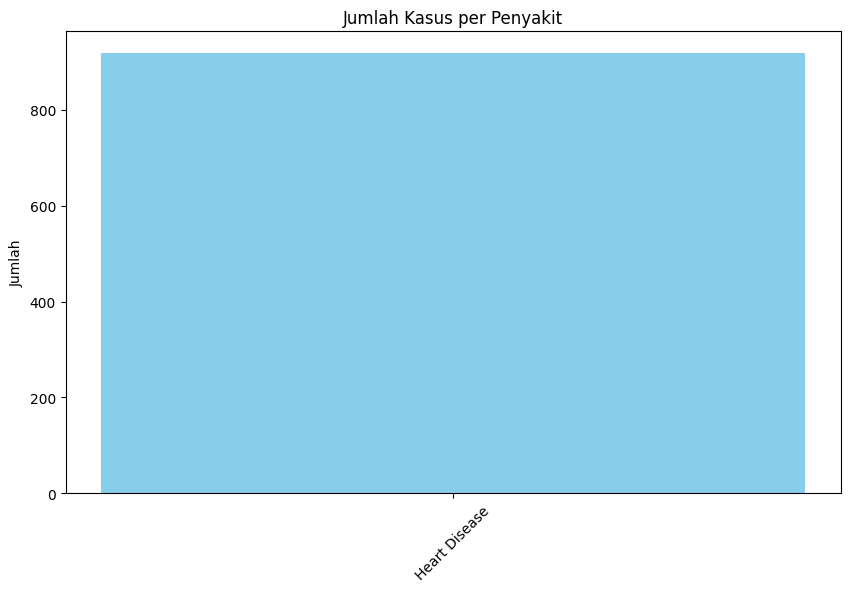

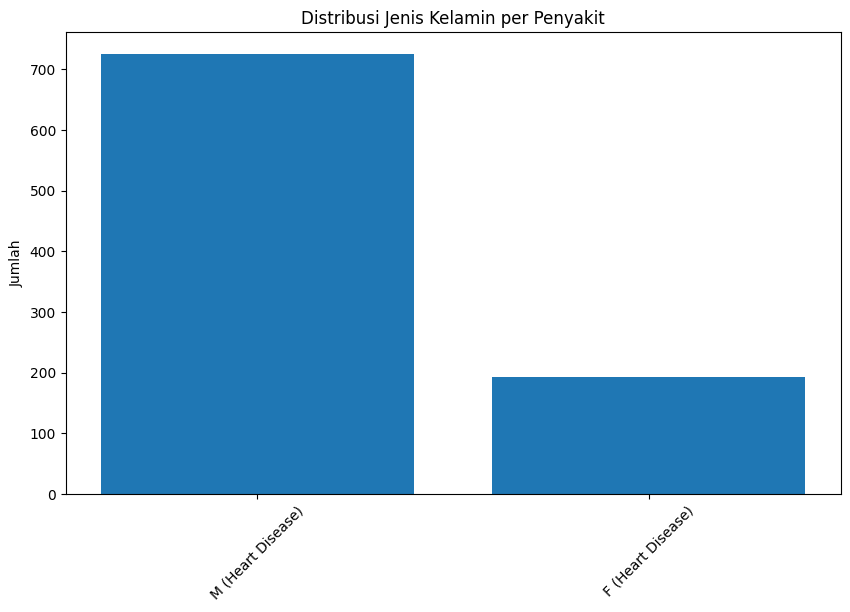

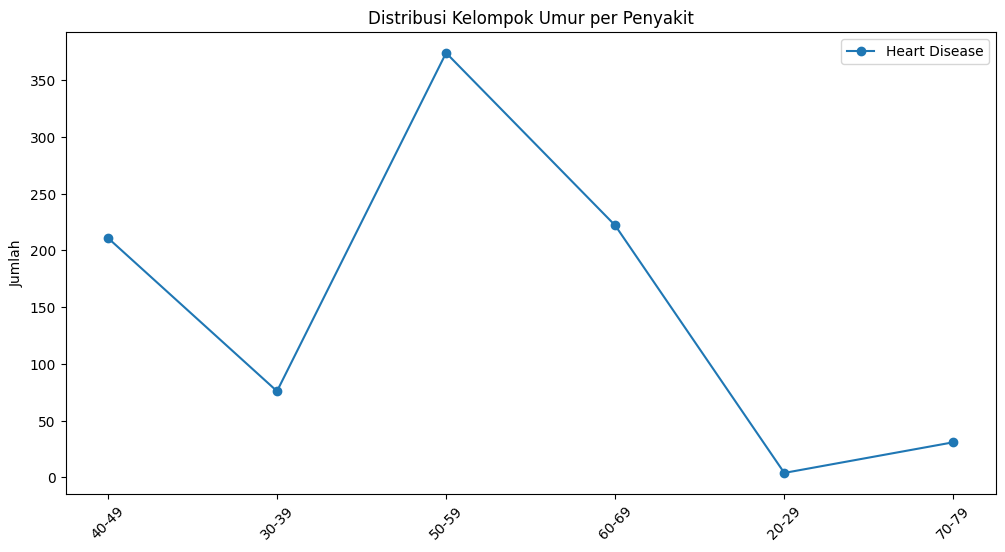

In [81]:
# Kolom yang kita butuhkan (supaya konsisten)
columns_needed = ["Age", "Sex", "JenisPenyakit"]

# Tambahkan kolom 'JenisPenyakit' di masing-masing dataset
df_heart = df_heart.withColumn("JenisPenyakit", lit("Heart Disease"))
df_cancer = df_cancer.withColumn("JenisPenyakit", lit("Cancer"))
df_liver = df_liver.withColumn("JenisPenyakit", lit("Liver Disease"))

def add_missing_cols(df, columns):
    existing_cols = df.columns
    missing_cols = [c for c in columns if c not in existing_cols]
    for col_name in missing_cols:
        # Asumsikan Age tipe int, Sex dan JenisPenyakit string
        if col_name == "Age":
            df = df.withColumn(col_name, lit(None).cast(IntegerType()))
        else:
            df = df.withColumn(col_name, lit(None).cast(StringType()))
    return df.select(columns)

# Perbaiki tiap dataframe agar kolomnya sama
df_heart_fixed = add_missing_cols(df_heart, columns_needed)
df_cancer_fixed = add_missing_cols(df_cancer, columns_needed)
df_liver_fixed = add_missing_cols(df_liver, columns_needed)

# Gabungkan semua
df_all = df_heart_fixed.unionByName(df_cancer_fixed).unionByName(df_liver_fixed)

# Ambil data untuk multiprocessing
raw_data = df_all.select("JenisPenyakit", "Sex", "Age").dropna().rdd.map(lambda row: (row[0], row[1], row[2])).collect()

# Fungsi hitung jumlah kasus JenisPenyakit
def count_disease(disease_list):
    result = {}
    for d in disease_list:
        key = d[0]
        result[key] = result.get(key, 0) + 1
    return result

# Fungsi hitung distribusi Sex per JenisPenyakit
def count_sex(data_list):
    result = {}
    for d in data_list:
        key = (d[0], d[1])  # (JenisPenyakit, Sex)
        result[key] = result.get(key, 0) + 1
    return result

# Fungsi hitung distribusi Age group per JenisPenyakit
def count_age_group(data_list):
    result = {}
    for d in data_list:
        age_raw = d[2]
        try:
            age = int(float(age_raw))  # coba konversi string ke float dulu, baru int
        except:
            continue  # skip data yang gak valid
        age_group = f"{(age//10)*10}-{(age//10)*10+9}"
        key = (d[0], age_group)
        result[key] = result.get(key, 0) + 1
    return result

def merge_dicts(dicts):
    merged = {}
    for d in dicts:
        for k, v in d.items():
            merged[k] = merged.get(k, 0) + v
    return merged

# Bagi data ke core CPU
chunks = np.array_split(raw_data, mp.cpu_count())

with mp.Pool() as pool:
    counts_disease = pool.map(count_disease, chunks)
    counts_sex = pool.map(count_sex, chunks)
    counts_age = pool.map(count_age_group, chunks)

final_disease = merge_dicts(counts_disease)
final_sex = merge_dicts(counts_sex)
final_age = merge_dicts(counts_age)

# Ubah ke pandas dataframe untuk plotting
df_disease = pd.DataFrame(list(final_disease.items()), columns=["JenisPenyakit", "Jumlah"])
df_sex = pd.DataFrame([(k[0], k[1], v) for k,v in final_sex.items()], columns=["JenisPenyakit", "Sex", "Jumlah"])
df_age = pd.DataFrame([(k[0], k[1], v) for k,v in final_age.items()], columns=["JenisPenyakit", "AgeGroup", "Jumlah"])

# Plot jumlah kasus per penyakit
plt.figure(figsize=(10,6))
plt.bar(df_disease["JenisPenyakit"], df_disease["Jumlah"], color='skyblue')
plt.title("Jumlah Kasus per Penyakit")
plt.xticks(rotation=45)
plt.ylabel("Jumlah")
plt.show()

# Plot distribusi jenis kelamin per penyakit
plt.figure(figsize=(10,6))
for penyakit in df_sex["JenisPenyakit"].unique():
    subset = df_sex[df_sex["JenisPenyakit"] == penyakit]
    plt.bar(subset["Sex"] + " (" + penyakit + ")", subset["Jumlah"], label=penyakit)
plt.title("Distribusi Jenis Kelamin per Penyakit")
plt.xticks(rotation=45)
plt.ylabel("Jumlah")
plt.show()

# Plot distribusi kelompok umur per penyakit
plt.figure(figsize=(12,6))
for penyakit in df_age["JenisPenyakit"].unique():
    subset = df_age[df_age["JenisPenyakit"] == penyakit]
    plt.plot(subset["AgeGroup"], subset["Jumlah"], marker='o', label=penyakit)
plt.title("Distribusi Kelompok Umur per Penyakit")
plt.xticks(rotation=45)
plt.ylabel("Jumlah")
plt.legend()
plt.show()


In [79]:
import psutil
print(f"Jumlah CPU tersedia: {psutil.cpu_count(logical=True)}")
print(f"Penggunaan CPU saat ini: {psutil.cpu_percent()}%")


Jumlah CPU tersedia: 2
Penggunaan CPU saat ini: 14.8%
